# Model Analysis

## Import relevant files
Look at some basic model attribures like features selected, and examine links between toy example, Metolazone and osteoporosis

In [1]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict

from hetnet_ml.extractor import MatrixFormattedGraph
from data_tools.graphs import dataframes_to_metagraph, metapaths_to_json
from data_tools import graphs as gt
from data_tools import combine_nodes_and_edges
from data_tools import plotting as gp
from data_tools.plotting import count_plot_h

/home/rogertu/projects/MechRepoNet/mrn_venv/lib/python3.8/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
load_dir = Path('../2_pipeline').resolve()
model_name = '15_Final_Model_Training'

nw_dir = load_dir.joinpath('12d_Preprocessing-Abbreviations_and_Biolink', 'out')
hyp_dir = load_dir.joinpath('13c_Model_Prep_Hyperparam_tuning', 'out')
model_dir = load_dir.joinpath(model_name, 'out')

In [3]:
this_name = '16a_Model_results_analysis_osteoporosis'
out_dir = load_dir.joinpath(this_name, 'out')
out_dir.mkdir(exist_ok=True, parents=True)

#imat_asth.to_csv(out_dir.joinpath('imat_asth_paths.csv'), index=False)

In [4]:
nodes = pd.read_csv(nw_dir.joinpath('nodes_biolink.csv'), dtype=str)
edges = pd.read_csv(nw_dir.joinpath('edges_biolink.csv'), dtype=str)

In [5]:
best_param = pickle.load(open(hyp_dir.joinpath('best_param.pkl'), 'rb'))

In [6]:
mg = MatrixFormattedGraph(nodes, edges, 'ChemicalSubstance', 'Disease', max_length=4, w=best_param['w'], n_jobs=30)

Processing node and edge data...
Initializing metagraph...
Generating adjacency matrices...


100%|███████████████████████████████████████████████████████████████████| 68/68 [01:08<00:00,  1.01s/it]



Determining degrees for each node and metaedge


100%|███████████████████████████████████████████████████████████████████| 68/68 [01:16<00:00,  1.12s/it]



Weighting matrices by degree with dampening factor 0.5665616931869023...


100%|███████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 50.47it/s]


In [7]:
model = pickle.load(open(model_dir.joinpath('model.pkl'), 'rb'))

/home/rogertu/projects/MechRepoNet/mrn_venv/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MaxAbsScaler from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/rogertu/projects/MechRepoNet/mrn_venv/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/rogertu/projects/MechRepoNet/mrn_venv/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [8]:
coef = pd.read_csv(model_dir.joinpath('coef.csv'))
mech_mps = pd.read_csv('../0_data/manual/mech_mps.txt', header=None)[0].values

In [9]:
metapaths = coef.query('feature != "intercept"')['feature'].tolist()

In [10]:
metagraph = dataframes_to_metagraph(nodes, edges)
all_metapaths = metagraph.extract_metapaths('ChemicalSubstance', 'Disease', 4)
mp_info = {mp.abbrev: mp for mp in all_metapaths if mp.abbrev in metapaths}

In [11]:
pos_coef = coef.query('coef > 0')['feature'].tolist()
coef.query('coef > 0').head(15)

,feature,coef,zcoef
0,CafBPawD,3.735980,0.273837
1,CafGrxCtD,2.335925,0.148932
2,CafGpoBPpoCtD,2.308317,0.146847
3,CafBPawPmCtD,1.983815,0.190773
4,CpoPWpoGrCtD,1.519787,0.055281
5,CinGpoPWawD,1.449461,0.124888
6,CafGpoPWpoCtD,1.294288,0.118364
7,CinGpoPWpoCtD,1.260486,0.114077
8,CinGpoBPitTcD,1.147065,0.057824
9,CinBPawD,1.106648,0.092215


In [12]:
msat = model[0]
max_abs = model[1]
ini_means = {f: m for f, m in zip(metapaths, msat.initial_mean_)}
ma_scale = {f: m for f, m in zip(metapaths, max_abs.scale_)}
feat_coef = coef.set_index('feature')['coef'].to_dict()
feat_zcoef = coef.set_index('feature')['zcoef'].to_dict()

node_labels = nodes['label'].unique()

## Examine model results

In [13]:
res = pd.read_csv(model_dir.joinpath('results.csv'))
res = res.sort_values('proba', ascending=False).reset_index(drop=True)

len(res)

90996724

In [14]:
id_to_name = nodes.set_index('id')['name'].to_dict()
res['chem_name'] = res['chemicalsubstance_id'].map(id_to_name)
res['dis_name'] = res['disease_id'].map(id_to_name)

res.head(2)

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
0,CHEBI:53769,MONDO:0005399,0,0.997371,(S)-acenocoumarol,venous thromboembolism
1,CHEBI:50438,MONDO:0005399,0,0.997320,phenprocoumon,venous thromboembolism


In [15]:
def get_model_metric(path_df):
    '''
    
    '''
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metapath'].map(totals) / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    model_metric = scal_metric * path_df['metapath'].map(feat_coef) * percent_of_total
    return model_metric

In [16]:
def get_std_model_metric(path_df):
    '''
    Differs from model_metric by scoring the trans_metric by metric instead of metapath totals
    '''
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metric'] / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    model_metric = scal_metric * path_df['metapath'].map(feat_zcoef) * percent_of_total
    return model_metric

In [17]:
def get_path_info(compound, disease, n_jobs=30):
    '''
    Looks for all paths between a given compound and disease, and returns the filtered dataframe
    '''
    path_df = pd.DataFrame(mg.extract_paths(compound, disease, pos_coef, n_jobs=n_jobs))
    path_df['model_metric'] = get_model_metric(path_df)
    path_df['std_metric'] = get_std_model_metric(path_df)
    
    return path_df

In [18]:
def find_nodes_by_name(sub_str, n_type=None):
    '''
    Looks for a "sub_str" in column "names" and returns a filtered dataframe
    '''
    if n_type is not None:
        qr = nodes.query('label == @n_type')   
    else:
        qr = nodes
    
    return qr[qr['name'].str.contains(sub_str)]

In [19]:
nodes.loc[nodes[nodes['name'].isnull()].index, 'name'] = nodes.loc[nodes[nodes['name'].isnull()].index, 'id']

## Look for Mosapramine

In [20]:
find_nodes_by_name('mosaprami', n_type='ChemicalSubstance')

,id,name,label,xrefs,source,synonyms,alt_ids,subsets
82175,CHEBI:135775,mosapramine,ChemicalSubstance,133chloro1011dihydro5hdibenzbfazepin5ylpropylh...,gvk,NaN,NaN,NaN


In [21]:
res.query('chemicalsubstance_id == "CHEBI:135775"').head()

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
29347,CHEBI:135775,DOID:9975,0,0.441287,mosapramine,cocaine dependence
29717,CHEBI:135775,DOID:809,0,0.439186,mosapramine,cocaine abuse
42194,CHEBI:135775,MESH:D002375,0,0.377776,mosapramine,Catalepsy
56824,CHEBI:135775,DOID:9854,0,0.326982,mosapramine,lingual-facial-buccal dyskinesia
96813,CHEBI:135775,DOID:480,0,0.242673,mosapramine,movement disease


### Look for osteoporosis

In [22]:
find_nodes_by_name('osteoporosis', n_type='Disease')

,id,name,label,xrefs,source,synonyms,alt_ids,subsets
68741,DOID:0060343,glucocorticoid-induced osteoporosis,Disease,DOID:0060343|DOID:60343|MESH:D010024|MONDO:000...,NaN,steroid-induced osteoporosis,NaN,NaN
69142,DOID:0060849,osteoporosis-pseudoglioma syndrome,Disease,DOID:0060849|GARD:4160|MESH:C536063|MONDO:0009...,NaN,OPPG|ocular form of osteogenesis imperfecta,NaN,NCIthesaurus
69576,DOID:0080077,hypophosphatemic nephrolithiasis/osteoporosis 1,Disease,DOID:0080077|MESH:C567363|MONDO:0012850|OMIM:6...,NaN,NaN,NaN,NaN
69577,DOID:0080078,hypophosphatemic nephrolithiasis/osteoporosis 2,Disease,DOID:0080078|MESH:C567362|MONDO:0012851|OMIM:6...,NaN,NaN,NaN,NaN
72518,DOID:11476,osteoporosis,Disease,DOID:11476|EFO:0003882|ICD10CM:M81.0|ICD9CM:73...,NaN,NaN,NaN,NCIthesaurus
72935,DOID:12559,idiopathic juvenile osteoporosis,Disease,DOID:12559|ICD9CM:733.02|MESH:C537700|MONDO:00...,NaN,Idiopathic osteoporosis|juvenile osteoporosis,NaN,NaN
75796,DOID:50671,Breast cancer in postmenopausal women with ost...,Disease,MESH:D001943|MESH:D015674,NaN,NaN,NaN,NaN
80464,MONDO:0018315,X-linked osteoporosis with fractures,Disease,MONDO:0018315|OMIM:300910,NaN,NaN,NaN,NaN


In [23]:
drug = 'CHEBI:64354'
dis = list(find_nodes_by_name('osteoporosis', n_type='Disease')['id'])

In [24]:
res.query('chemicalsubstance_id == @drug and disease_id == @dis')

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
694832,CHEBI:64354,DOID:50671,0,0.064827,metolazone,Breast cancer in postmenopausal women with ost...
2481787,CHEBI:64354,DOID:0060343,0,0.025200,metolazone,glucocorticoid-induced osteoporosis
4550573,CHEBI:64354,DOID:11476,0,0.016109,metolazone,osteoporosis
7197255,CHEBI:64354,DOID:0080077,0,0.011558,metolazone,hypophosphatemic nephrolithiasis/osteoporosis 1
8623623,CHEBI:64354,DOID:0060849,0,0.010181,metolazone,osteoporosis-pseudoglioma syndrome
8923656,CHEBI:64354,DOID:12559,0,0.009945,metolazone,idiopathic juvenile osteoporosis
68090309,CHEBI:64354,DOID:0080078,0,0.005157,metolazone,hypophosphatemic nephrolithiasis/osteoporosis 2


### Extract paths between metolazone and osteoporosis

In [25]:
drug_dis1 = get_path_info(drug, 'DOID:0060343', n_jobs=30)
drug_dis2 = get_path_info(drug, 'DOID:11476', n_jobs=30)

100%|███████████████████████████████████████████████████████████████████| 89/89 [00:01<00:00, 68.77it/s]


In [26]:
drug_dis1_paths = drug_dis1.sort_values('model_metric', ascending=False).reset_index(drop=True)
drug_dis2_paths = drug_dis2.sort_values('model_metric', ascending=False).reset_index(drop=True)

In [27]:
len(drug_dis1_paths)

8013

In [28]:
len(drug_dis2_paths)

8659

### Find the target of metolazone and osteoporosis
* SLC12a3
* CYP3a4

In [29]:
find_nodes_by_name('SLC12', n_type='MacromolecularMachine')

,id,name,label,xrefs,source,synonyms,alt_ids,subsets
92034,NCBIGene:10723,SLC12A7,MacromolecularMachine,ENSG:ENSG00000113504|ENSG:ENSG00000276482|HGNC...,NaN,NaN,NaN,NaN
129012,NCBIGene:56996,SLC12A9,MacromolecularMachine,ENSG:ENSG00000146828|HGNC:17435|NCBIGene:56996...,NaN,NaN,NaN,NaN
129332,NCBIGene:57468,SLC12A5,MacromolecularMachine,ENSG:ENSG00000124140|HGNC:13818|NCBIGene:57468...,NaN,NaN,NaN,NaN
133864,NCBIGene:6557,SLC12A1,MacromolecularMachine,ENSG:ENSG00000074803|HGNC:10910|NCBIGene:6557|...,NaN,NaN,NaN,NaN
133865,NCBIGene:6558,SLC12A2,MacromolecularMachine,ENSG:ENSG00000064651|HGNC:10911|NCBIGene:6558|...,NaN,NaN,NaN,NaN
133866,NCBIGene:6559,SLC12A3,MacromolecularMachine,ENSG:ENSG00000070915|HGNC:10912|NCBIGene:6559|...,NaN,NaN,NaN,NaN
133868,NCBIGene:6560,SLC12A4,MacromolecularMachine,ENSG:ENSG00000124067|HGNC:10913|NCBIGene:6560|...,NaN,NaN,NaN,NaN
137970,NCBIGene:84561,SLC12A8,MacromolecularMachine,ENSG:ENSG00000221955|HGNC:15595|NCBIGene:84561...,NaN,NaN,NaN,NaN
140958,NCBIGene:9990,SLC12A6,MacromolecularMachine,ENSG:ENSG00000140199|HGNC:10914|NCBIGene:9990|...,NaN,NaN,NaN,NaN
215705,UniProt:P34261,SLC12A1,MacromolecularMachine,REACT:R-CEL-426139-2|REACT:R-CEL-426147-2,NaN,NaN,NaN,NaN


In [30]:
find_nodes_by_name('CYP3', n_type='MacromolecularMachine')

,id,name,label,xrefs,source,synonyms,alt_ids,subsets
89326,NCBIGene:100861540,CYP3A7-CYP3A51P,MacromolecularMachine,ENSG:ENSG00000282301|HGNC:51504|NCBIGene:10086...,NaN,NaN,NaN,NaN
99740,NCBIGene:1551,CYP3A7,MacromolecularMachine,ENSG:ENSG00000160870|HGNC:2640|NCBIGene:1551|O...,NaN,NaN,NaN,NaN
99781,NCBIGene:1576,CYP3A4,MacromolecularMachine,ENSG:ENSG00000160868|HGNC:2637|NCBIGene:1576|O...,NaN,NaN,NaN,NaN
99789,NCBIGene:1577,CYP3A5,MacromolecularMachine,ENSG:ENSG00000106258|HGNC:2638|NCBIGene:1577|O...,NaN,NaN,NaN,NaN
126847,NCBIGene:51302,CYP39A1,MacromolecularMachine,ENSG:ENSG00000146233|HGNC:17449|NCBIGene:51302...,NaN,NaN,NaN,NaN
133557,NCBIGene:64816,CYP3A43,MacromolecularMachine,ENSG:ENSG00000021461|HGNC:17450|NCBIGene:64816...,NaN,NaN,NaN,NaN
143105,WD:Q56735681,CYP32,MacromolecularMachine,NaN,NaN,NaN,NaN,NaN
146716,WD:Q59923196,CYP32,MacromolecularMachine,NaN,NaN,NaN,NaN,NaN
157046,WD:Q60005585,CYP32,MacromolecularMachine,NaN,NaN,NaN,NaN,NaN
157080,WD:Q60005744,CYP32,MacromolecularMachine,NaN,NaN,NaN,NaN,NaN


In [31]:
SLC = 'NCBIGene:6559'
CYP = 'NCBIGene:1576'

In [32]:
def query_target(path_df, tgt_id):
    tgt_ids = path_df['node_ids'].apply(lambda x: x[1])
    
    idx = tgt_ids == tgt_id
    idx = idx[idx].index
    
    return path_df.loc[idx]

In [33]:
def query_path_pos(path_df, tgt_id, pos=1):
    tgt_ids = path_df['node_ids'].apply(lambda x: x[pos] if len(x) > pos else float('nan'))
    
    idx = tgt_ids == tgt_id
    idx = idx[idx].index
    
    return path_df.loc[idx]

In [34]:
tgt_drug_dis1_slc_paths = query_target(drug_dis1_paths, SLC)
tgt_drug_dis2_slc_paths = query_target(drug_dis2_paths, SLC)

tgt_drug_dis1_cyp_paths = query_target(drug_dis1_paths, CYP)
tgt_drug_dis2_cyp_paths = query_target(drug_dis2_paths, CYP)

In [35]:
edge_info = pd.read_csv('../0_data/manual/edge_semtypes.csv')
inv_map = edge_info.set_index('fwd_edge')['rev_edge'].to_dict()

In [36]:
id_to_label = nodes.set_index('id')['label'].to_dict()

c = combine_nodes_and_edges(nodes, edges)

In [37]:
# Choose custom node colors
# node_color_map = {'AnatomicalEntity': '#5252b9',
#                 'BiologicalProcessOrActivity': '#fc99d5',
#                 'MacromolecularMachine': '#d032a3',
#                 'Disease': '#50e316',
#                 'Pathway': '#b7d165',
#                 'PhenotypicFeature': '#165f28',
#                 'GeneFamily': '#6404b7',
#                 'PhysiologicalProcess': '#ec102f',
#                 'OrganismTaxon': '#e9bf98',
#                 'ChemicalSubstance': '#21f0b6'}

node_color_map = {'AnatomicalEntity': "#8c88d7",
                'BiologicalProcessOrActivity': "#b75970",
                'MacromolecularMachine': "#e71761",
                'Disease': "#70c6ca",
                'Pathway': "#b1d34f",
                'PhenotypicFeature': "#154e56",
                'GeneFamily': "#5a3386",
                'PhysiologicalProcess': '#ec102f',
                'OrganismTaxon': "#e9bf98",
                'ChemicalSubstance': "#01c472",}

node_id_to_color = nodes.set_index('id')['label'].map(node_color_map).to_dict()

#### Treatments for Osteoporosis

#### Potential indications for Metolazone Stat

In [50]:
res.query('chemicalsubstance_id == @drug')

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
109065,CHEBI:64354,MESH:D016063,0,0.226209,metolazone,Surgical Blood Losses
150818,CHEBI:64354,MESH:D056486,0,0.185384,metolazone,Hepatic injury
198116,CHEBI:64354,DOID:0050445,0,0.155550,metolazone,X-linked dominant hypophosphatemic rickets
277735,CHEBI:64354,MESH:D055013,0,0.124078,metolazone,"Osteoarthritis, Spine"
292836,CHEBI:64354,DOID:10763,1,0.119678,metolazone,hypertension
...,...,...,...,...,...,...
90802889,CHEBI:64354,DOID:11684,0,0.001104,metolazone,melanoacanthoma
90802890,CHEBI:64354,DOID:6945,0,0.001104,metolazone,inverted follicular keratosis
90802891,CHEBI:64354,DOID:11685,0,0.001104,metolazone,inflamed seborrheic keratosis
90840497,CHEBI:64354,DOID:589,0,0.001038,metolazone,congenital hemolytic anemia


In [69]:
metolazone_subset_res = res.query('disease_id =="DOID:0060343"').reset_index(drop=True)
len(metolazone_subset_res)

14084

In [72]:
metolazone_subset_res.query('chemicalsubstance_id == @drug')

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
3214,CHEBI:64354,DOID:0060343,0,0.0252,metolazone,glucocorticoid-induced osteoporosis


In [73]:
# metalozone percentile
1 - ((metolazone_subset_res.query('chemicalsubstance_id == @drug').index[0]+1) / len(metolazone_subset_res))

0.7717267821641579

In [52]:
osteo_subset_res = res.query('chemicalsubstance_id == @drug').reset_index(drop=True)
len(osteo_subset_res)

6461

In [53]:
osteo_subset_res.query('disease_id == @dis')

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
24,CHEBI:64354,DOID:50671,0,0.064827,metolazone,Breast cancer in postmenopausal women with ost...
239,CHEBI:64354,DOID:0060343,0,0.025200,metolazone,glucocorticoid-induced osteoporosis
557,CHEBI:64354,DOID:11476,0,0.016109,metolazone,osteoporosis
1026,CHEBI:64354,DOID:0080077,0,0.011558,metolazone,hypophosphatemic nephrolithiasis/osteoporosis 1
1305,CHEBI:64354,DOID:0060849,0,0.010181,metolazone,osteoporosis-pseudoglioma syndrome
1365,CHEBI:64354,DOID:12559,0,0.009945,metolazone,idiopathic juvenile osteoporosis
4257,CHEBI:64354,DOID:0080078,0,0.005157,metolazone,hypophosphatemic nephrolithiasis/osteoporosis 2


In [54]:
# Obesity's percentile
1 - ((osteo_subset_res.query('disease_id == @dis').index[0]+1) / len(osteo_subset_res))

0.9961306299334468

In [65]:
res.query('chemicalsubstance_id == @drug and disease_id == "DOID:0060343"')

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
2481787,CHEBI:64354,DOID:0060343,0,0.0252,metolazone,glucocorticoid-induced osteoporosis


In [66]:
len(res)

90996724

In [67]:
##  Overall percentile
1 - ((res.query('chemicalsubstance_id == @drug and disease_id == @dis').index[0]+1) / len(res))

0.9923641976385875

## Draw some explainations

In [39]:
# Imports for plotting results
%matplotlib inline

import networkx as nx
import seaborn as sns
from scipy.spatial import distance
from collections import defaultdict
import matplotlib.pyplot as plt

# networkx throws LOTS of matplotlib warnings when plotting, so we're silencing
import warnings
warnings.simplefilter('ignore')

In [40]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

In [41]:
def draw_top_paths(path_df, head_num=10, metric='model_metric', poi_idx=None, proba=None):
    '''
    Draws a pathway diagram from drug to disease
    
    Input:
    ------------
    path_df:   dataframe of paths
    head_num:  top number of paths to display
    metric:    top metrics from which type of metric? {'model_metric','metric',}
    poi_idx:   from a given list of paths, provide the index of which to highlight      
    proba:     float, a value to be printed next to the name of the start node. Denotes probability of treatment.
    '''
        
    top_n_paths = path_df.sort_values(metric, ascending=False).head(head_num)

    # Get the list of paths
    list_of_paths = top_n_paths['node_ids'].tolist()
    path_weights = top_n_paths[metric].tolist()

    # Get the edge names
    list_of_edges = []
    for mp in top_n_paths['metapath']:
        list_of_edges.append(gp.parse_metapath_to_edge_names(mp, mp_info, inv_map))


    
    if type(poi_idx) == list:
        ec = []
        for idx in poi_idx:
            poi = path_df.loc[idx, 'node_ids']
            ec.append(gp.highlight_path_of_interest(list_of_paths, poi))
        
        # Take the edges from the first highlighted poi
        edge_color_map = ec[0]
        for ecm in ec[1:]:
            for k, v in ecm.items():
                # Any other highlihted paths get marked
                # seaborn 1 is highlight color.
                if v == sns.color_palette().as_hex()[1]:
                    edge_color_map[k] = v
        
    elif poi_idx is not None:
        path_of_interest = path_df.loc[poi_idx, 'node_ids']
        edge_color_map = gp.highlight_path_of_interest(list_of_paths, path_of_interest)
    else:
        path_of_interest = []
        edge_color_map = gp.highlight_path_of_interest(list_of_paths, path_of_interest)
    
    

    G = gp.build_explanitory_graph(list_of_paths, list_of_edges, path_weights=path_weights, 
                                node_id_to_label=id_to_label, node_id_to_color=node_id_to_color, 
                                edge_id_to_color=edge_color_map, min_dist=3)

    gp.draw_explanitory_graph(G, node_id_to_name=id_to_name, proba=proba, n_paths=10, xscale=17, title=False);

In [42]:
sns.set_palette('muted')

In [43]:
drug_dis1_paths

,node_ids,nodes,metapath,metric,model_metric,std_metric
0,"[CHEBI:64354, GO:0008217, DOID:0060343]","[metolazone, regulation of blood pressure, glu...",CafBPawD,3.790938e-06,1.369592e+00,1.003873e-01
1,"[CHEBI:64354, NCBIGene:6559, REACT:R-HSA-56191...","[metolazone, SLC12A3, Disorders of transmembra...",CinGpoPWawD,2.609238e-06,4.521417e-01,3.669303e-02
2,"[CHEBI:64354, NCBIGene:1576, GO:0036378, CHEBI...","[metolazone, CYP3A4, calcitriol biosynthetic p...",CafGpoBPpoCtD,6.128539e-07,3.783205e-01,1.992102e-02
3,"[CHEBI:64354, GO:0008217, DOID:0060343]","[metolazone, regulation of blood pressure, glu...",CinBPawD,4.445480e-06,3.028146e-01,2.523303e-02
4,"[CHEBI:64354, GO:0008217, HP:0010889, MESH:D00...","[metolazone, regulation of blood pressure, Mor...",CafBPawPmCtD,4.650772e-07,2.475445e-01,2.008574e-02
...,...,...,...,...,...,...
8008,"[CHEBI:64354, REACT:R-HSA-913531, NCBIGene:731...","[metolazone, Interferon Signaling, UBB, Signal...",CawPWpoGpoPWawD,2.458019e-12,9.606626e-09,7.665248e-15
8009,"[CHEBI:64354, REACT:R-HSA-913531, NCBIGene:731...","[metolazone, Interferon Signaling, UBA52, Sign...",CawPWpoGpoPWawD,2.335507e-12,9.127812e-09,6.920187e-15
8010,"[CHEBI:64354, REACT:R-HSA-913531, NCBIGene:623...","[metolazone, Interferon Signaling, RPS27A, Sig...",CawPWpoGpoPWawD,2.316199e-12,9.052353e-09,6.806242e-15
8011,"[CHEBI:64354, NCBIGene:8856, GO:0006351, NCBIG...","[metolazone, NR1I2, transcription, DNA-templat...",CafGrBPpoGawD,4.488156e-09,4.469144e-09,1.999496e-10


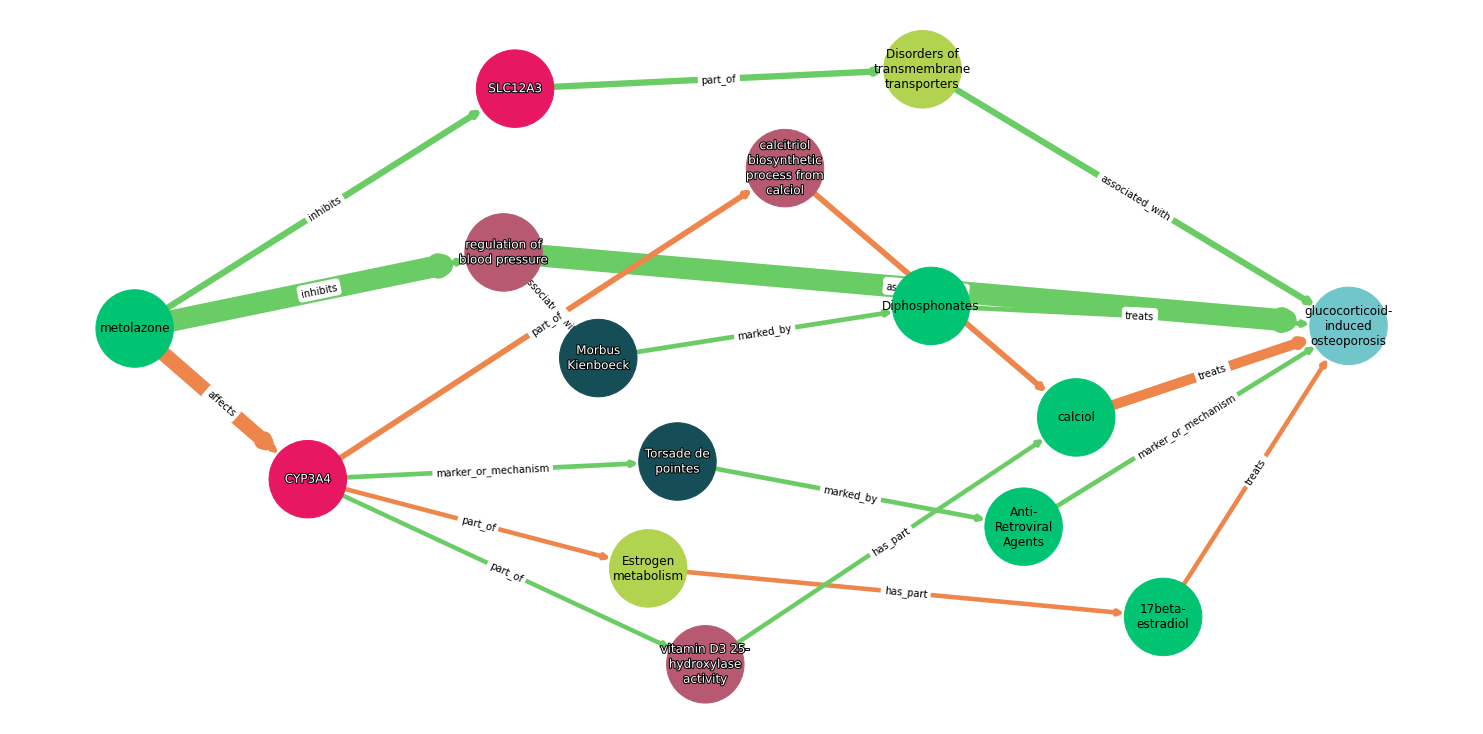

In [44]:
draw_top_paths(drug_dis1_paths, 8, 'model_metric', poi_idx = [2,6])#, poi_idx=5)
#plt.savefig(out_dir.joinpath('imat_asth_top10.pdf'))

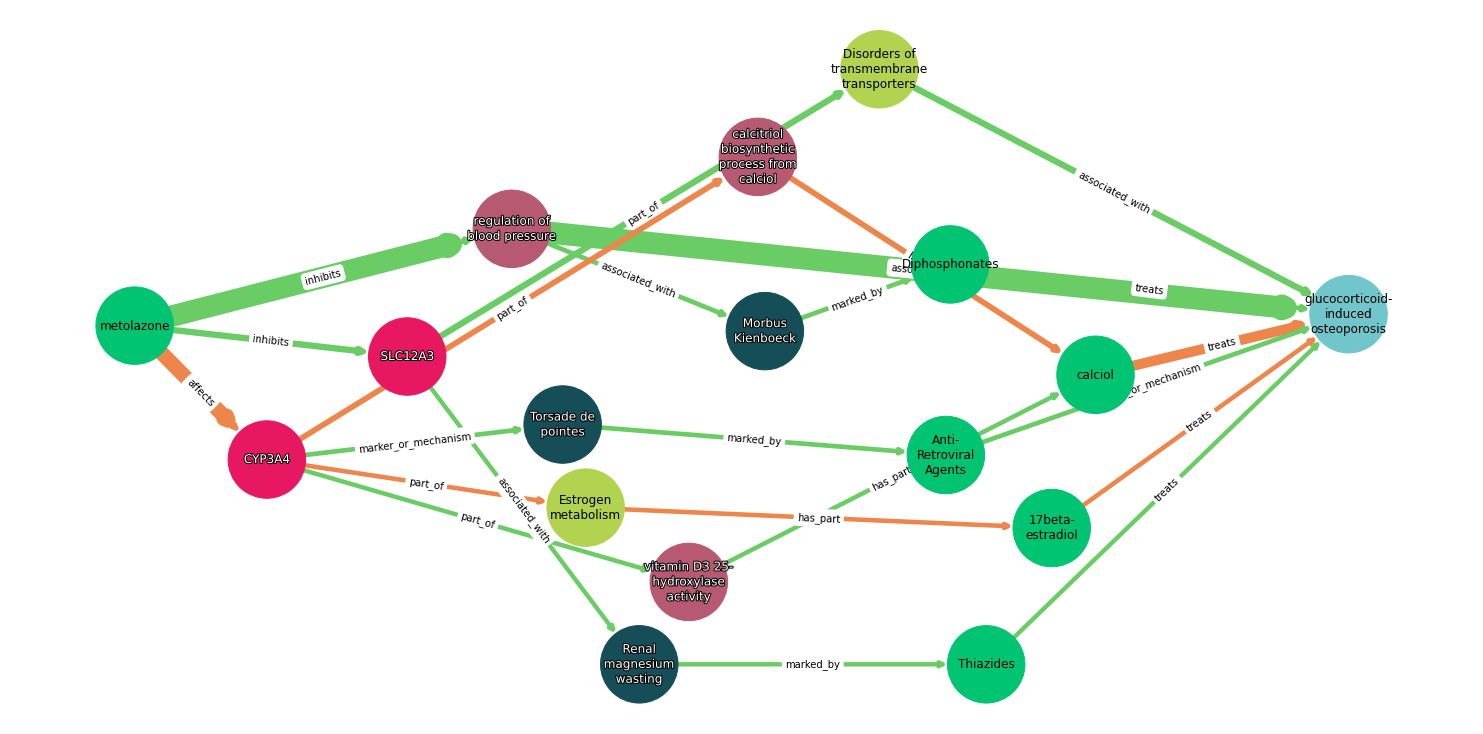

In [45]:
draw_top_paths(drug_dis1_paths, 9, 'model_metric', poi_idx = [2,6])#, poi_idx=5)
plt.savefig(out_dir.joinpath('metolazone_osteoporosis_top9.pdf'),dpi=400)

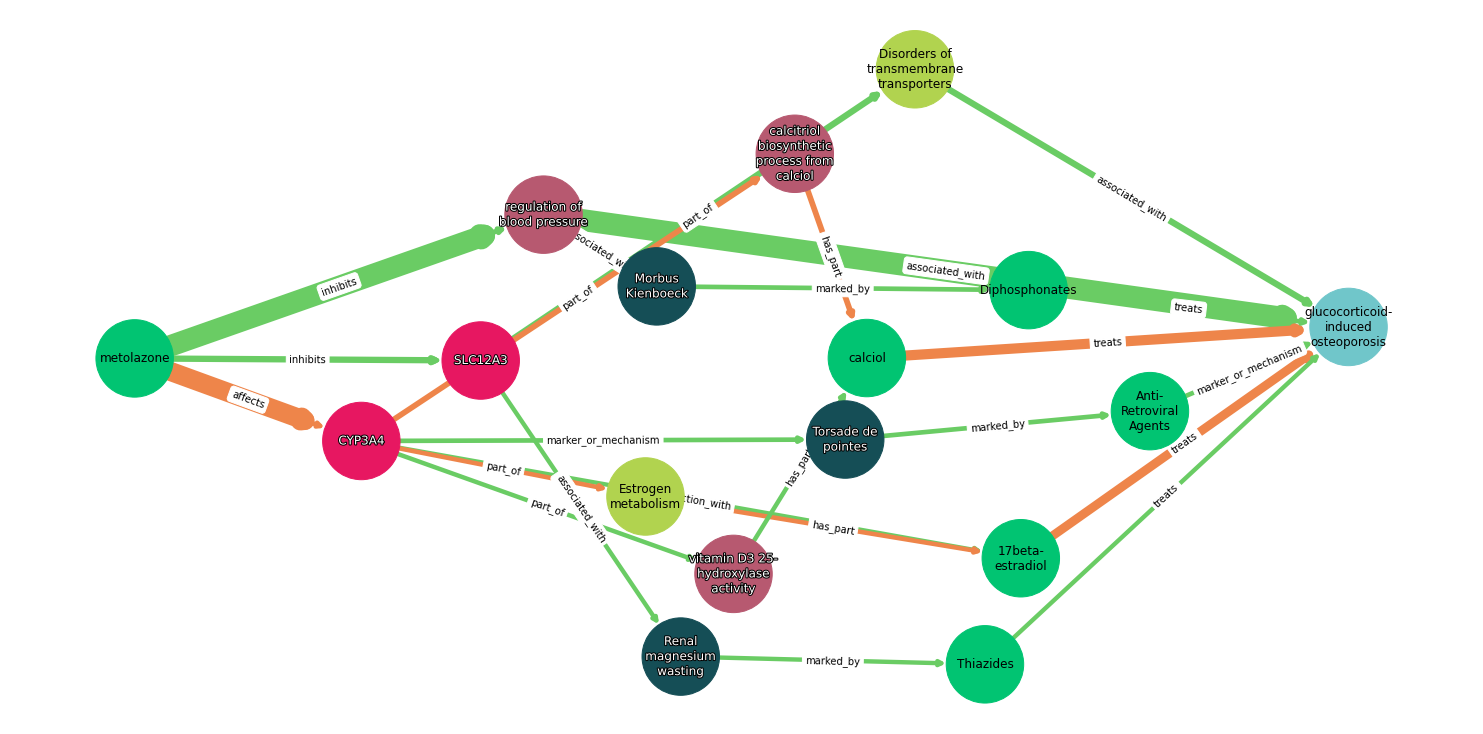

In [46]:
draw_top_paths(drug_dis1_paths, 10, 'model_metric', poi_idx = [2,6])#, poi_idx=5)
plt.savefig(out_dir.joinpath('metolazone_osteoporosis_top10.svg'),dpi=400)

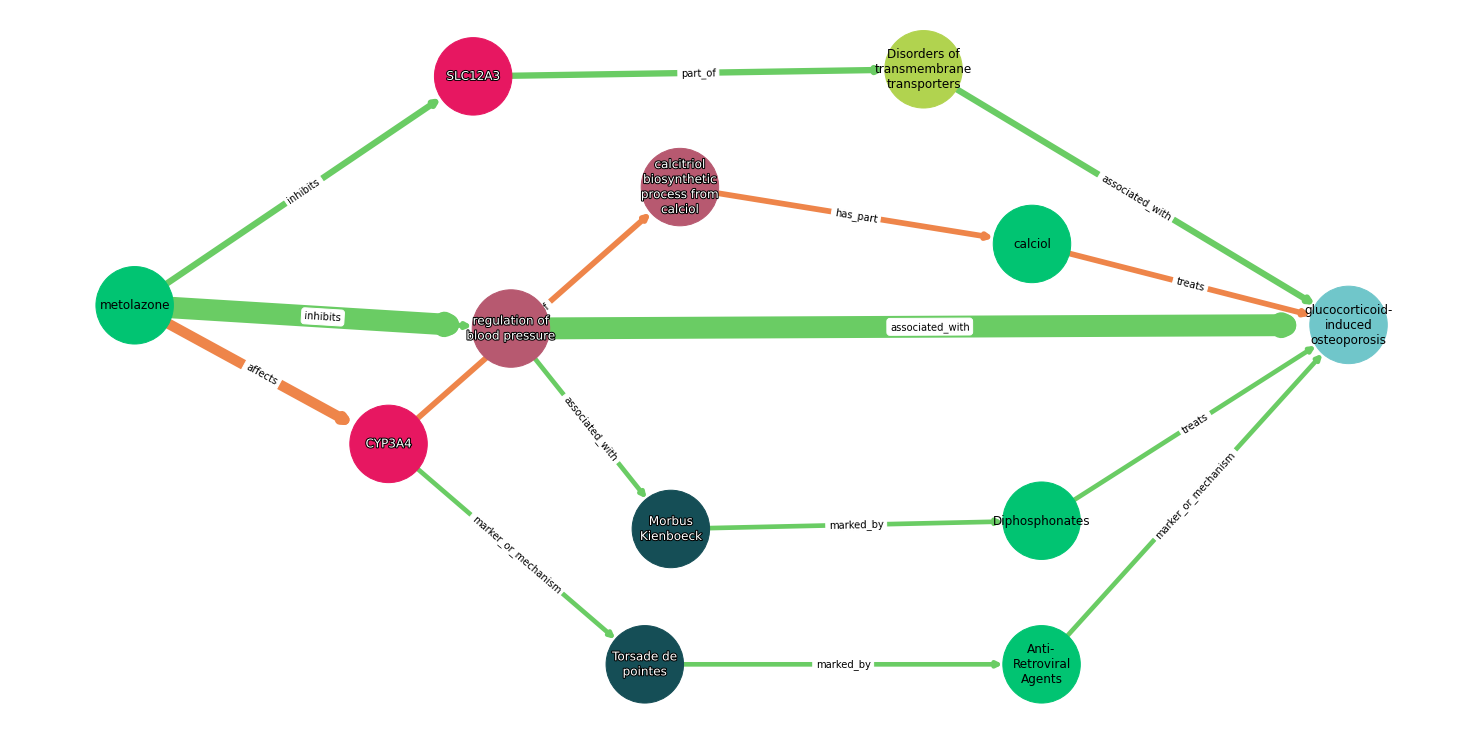

In [48]:
draw_top_paths(drug_dis1_paths,6, 'model_metric', poi_idx = [2,6])#, poi_idx=5)
#plt.savefig(out_dir.joinpath('metolazone_osteoporosis_top10.svg'),dpi=400)

In [52]:
drug_dis1_paths.head(20)

,node_ids,nodes,metapath,metric,model_metric,std_metric
0,"[CHEBI:64354, GO:0008217, DOID:0060343]","[metolazone, regulation of blood pressure, glu...",CafBPawD,3.790938e-06,1.369592,0.100387
1,"[CHEBI:64354, NCBIGene:6559, REACT:R-HSA-56191...","[metolazone, SLC12A3, Disorders of transmembra...",CinGpoPWawD,2.609238e-06,0.452142,0.036693
2,"[CHEBI:64354, NCBIGene:1576, GO:0036378, CHEBI...","[metolazone, CYP3A4, calcitriol biosynthetic p...",CafGpoBPpoCtD,6.128539e-07,0.378321,0.019921
3,"[CHEBI:64354, GO:0008217, DOID:0060343]","[metolazone, regulation of blood pressure, glu...",CinBPawD,4.445480e-06,0.302815,0.025233
4,"[CHEBI:64354, GO:0008217, HP:0010889, MESH:D00...","[metolazone, regulation of blood pressure, Mor...",CafBPawPmCtD,4.650772e-07,0.247544,0.020086
5,"[CHEBI:64354, NCBIGene:1576, HP:0001664, MESH:...","[metolazone, CYP3A4, Torsade de pointes, Anti-...",CafGmPmCmD,4.059421e-05,0.246369,0.020929
6,"[CHEBI:64354, NCBIGene:1576, WP:WP697, CHEBI:1...","[metolazone, CYP3A4, Estrogen metabolism, 17be...",CaGpoPWpoCtD,9.393086e-08,0.231110,0.017376
7,"[CHEBI:64354, NCBIGene:1576, GO:0030343, CHEBI...","[metolazone, CYP3A4, vitamin D3 25-hydroxylase...",CafGpoBPpoCtD,3.547271e-07,0.218976,0.009269
8,"[CHEBI:64354, NCBIGene:6559, HP:0005567, MESH:...","[metolazone, SLC12A3, Renal magnesium wasting,...",CafGawPmCtD,1.635160e-05,0.210847,0.014263
9,"[CHEBI:64354, NCBIGene:1576, CHEBI:16469, DOID...","[metolazone, CYP3A4, 17beta-estradiol, glucoco...",CafGrxCtD,5.078181e-07,0.202035,0.012881


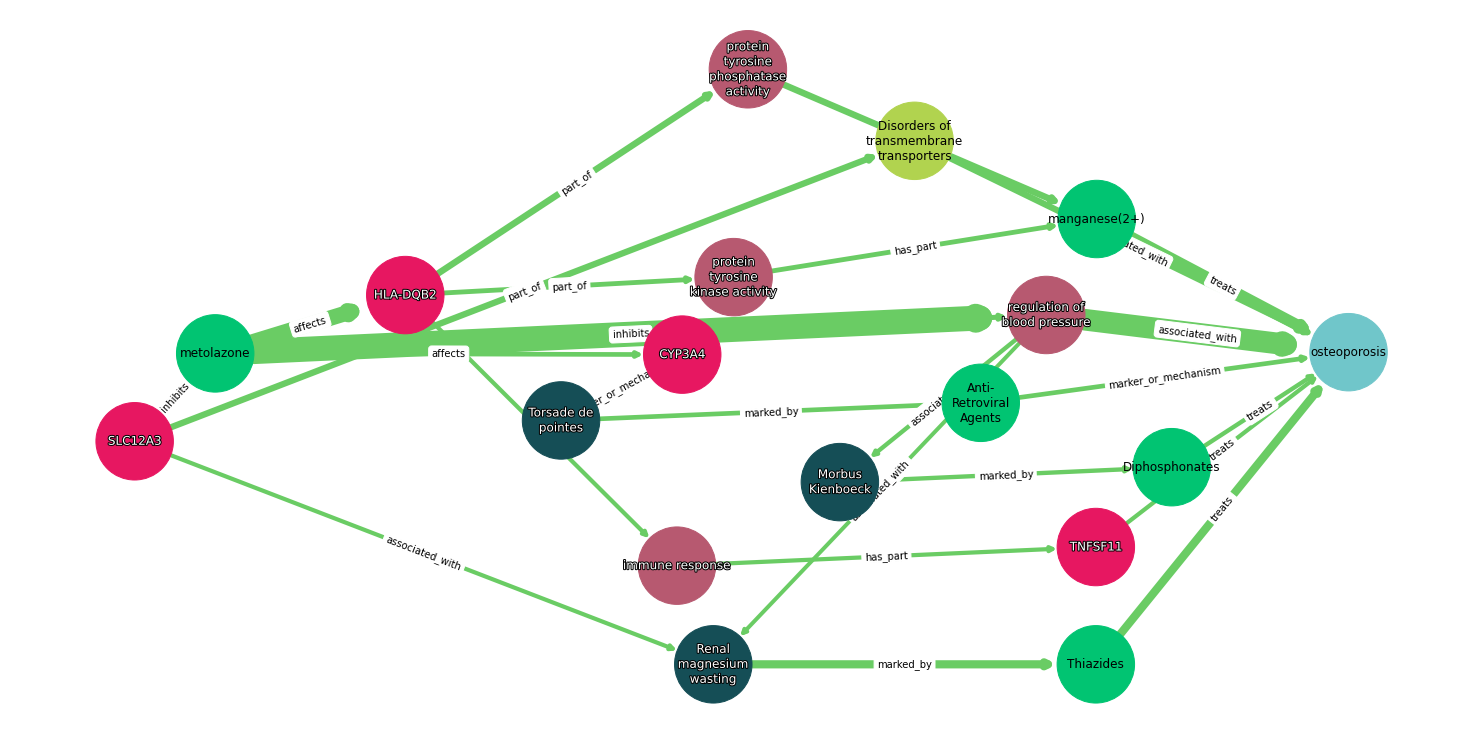

In [45]:
draw_top_paths(drug_dis2_paths, 10, 'model_metric')#, poi_idx=5)
#plt.savefig(out_dir.joinpath('imat_asth_top10.pdf'))

Targeting SLC12

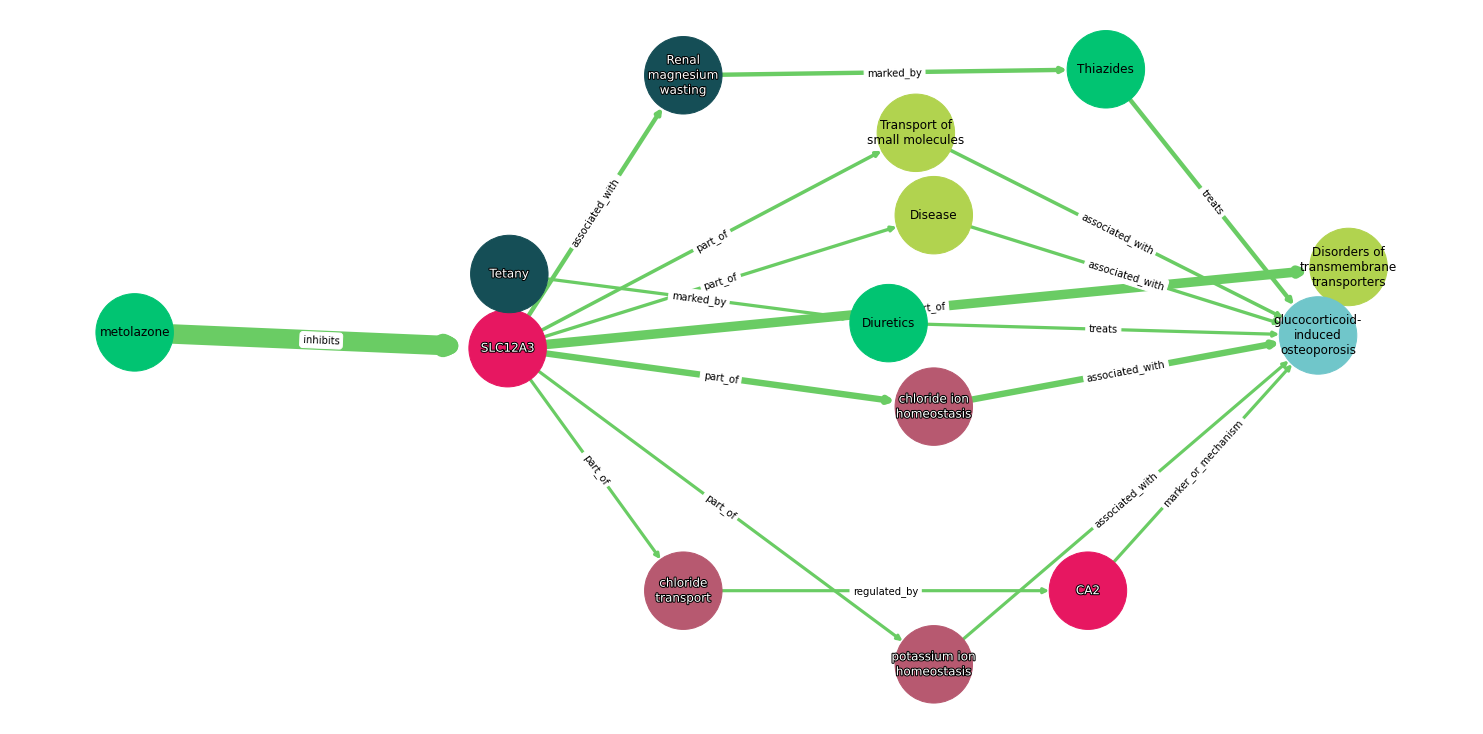

In [46]:
draw_top_paths(tgt_drug_dis1_slc_paths, 10, 'model_metric')#, poi_idx=5)

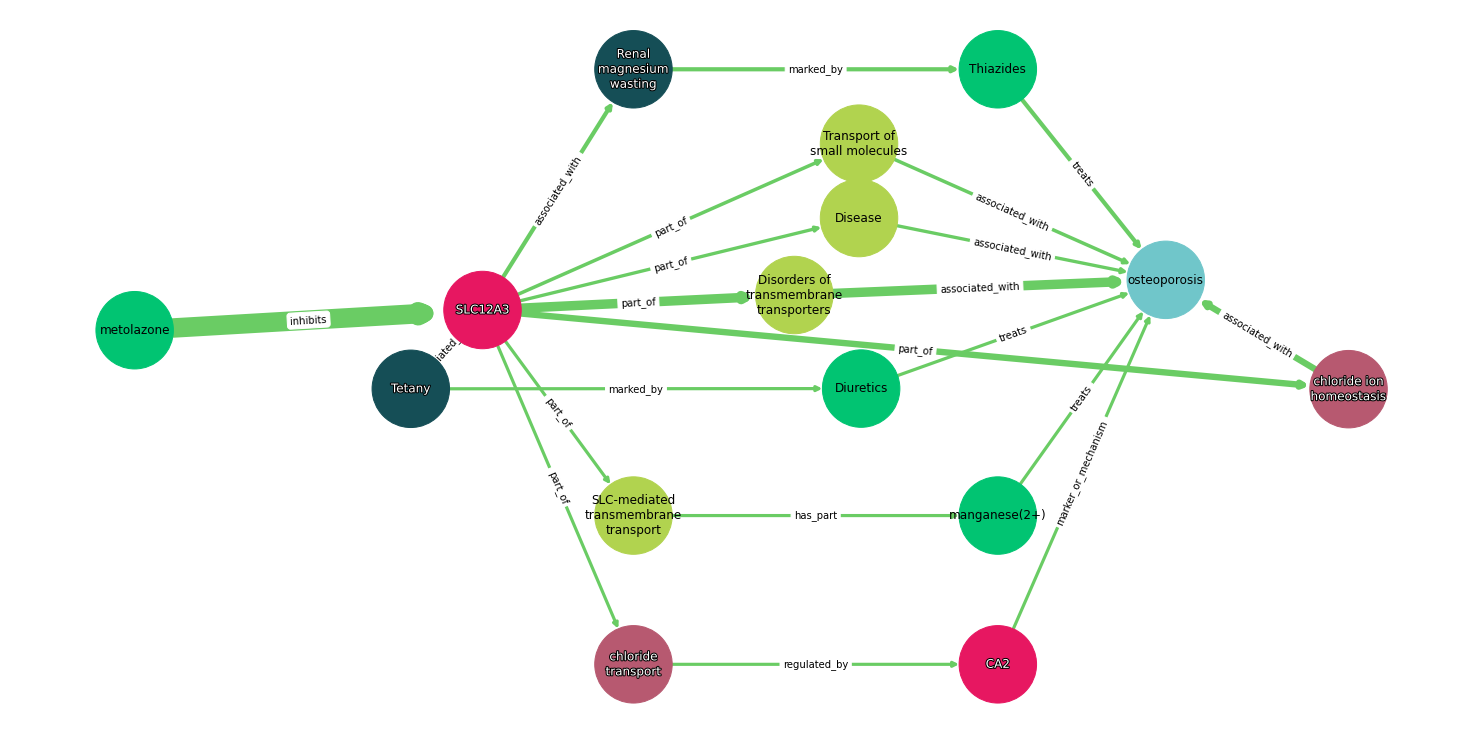

In [47]:
draw_top_paths(tgt_drug_dis2_slc_paths, 10, 'model_metric')#, poi_idx=5)

### targeting CYP3A4

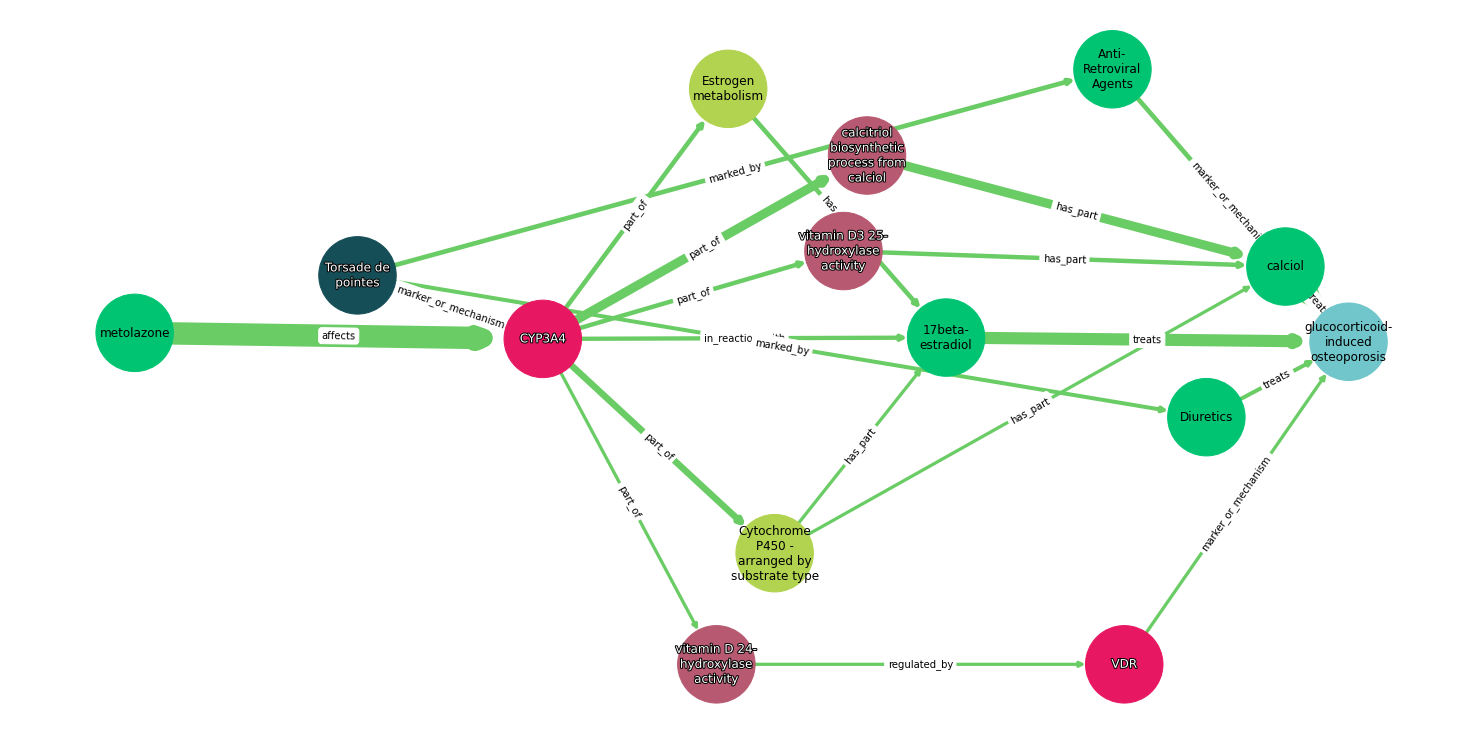

In [48]:
draw_top_paths(tgt_drug_dis1_cyp_paths, 10, 'model_metric')#, poi_idx=5)

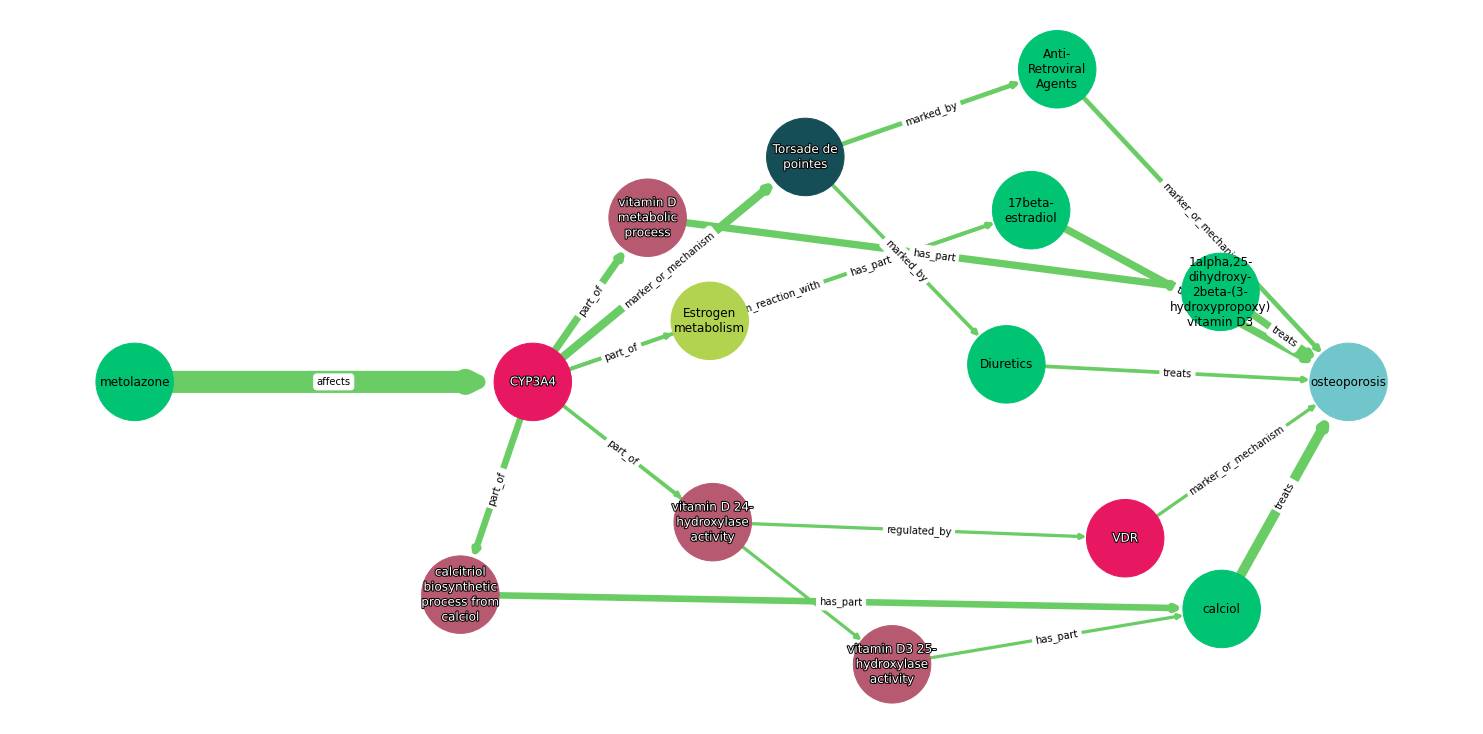

In [49]:
draw_top_paths(tgt_drug_dis2_cyp_paths, 10, 'model_metric')#, poi_idx=5)